## Библиотеки

In [95]:
import numpy as np
import matplotlib.pyplot as plt

## Функции

In [100]:
def fill_C(): # Заполнить сетку ненулевыми лямбдами
    C11 = 12.98344389516936
    C12 = 2.76656283641825
    C16 = 5.00630996992227
    C22 = 79.21121100901908
    C26 = 4.88188079023485
    C66 = 13.05325089362048
    C = np.array([(C11, C12, C16),
                  (C12, C22, C26),
                  (C16, C26, C66)])
    C *= 1e-9 # Гигапаскали - 10^9
    return C
            
def Omega(q, Omega):
    return Omega @ q

def Omega_inv(w, Omega_inv):
    q = Omega_inv @ w
    return (q[0], q[1], q[2], q[3], q[4])

## Переменные

In [115]:
L = 1 # масштаб координатных осей
M = 51 # количество узлов вдоль оси
#C =  np.ones((3, 3)) # Сетка лямбд
C = fill_C()
print("Matrix C =", '\n', C)
rho = 2200
h = L / M # шаг по координате, h
data_current = np.zeros((M, M), dtype=[('vx', np.float64), ('vy', np.float64), # По умолчанию нулевые элекменты
                                  ('sxx', np.float64), ('syy', np.float64), ('sxy', np.float64)])
data_next = np.zeros((M, M), dtype=[('vx', np.float64), ('vy', np.float64),
                                  ('sxx', np.float64), ('syy', np.float64), ('sxy', np.float64)])
#print(data_current[0, 0])

Matrix C = 
 [[1.29834439e-08 2.76656284e-09 5.00630997e-09]
 [2.76656284e-09 7.92112110e-08 4.88188079e-09]
 [5.00630997e-09 4.88188079e-09 1.30532509e-08]]


## Численные вычисления матриц

In [116]:
import scipy.linalg as sci

In [117]:
Ax = np.array([[0,         0,         -1/rho, 0, 0     ],
               [0,         0,         0,      0, -1/rho],
               [-C[0][0], -C[0][2]/2, 0,      0, 0     ],
               [-C[0][1], -C[1][2]/2, 0,      0, 0     ],
               [-C[0][2], -C[2][2]/2, 0,      0, 0     ]])

Ay = np.array([[0,           0,       0, 0,      -1/rho],
               [0,           0,       0, -1/rho, 0     ],
               [-C[0][2]/2, -C[0][1], 0, 0,      0     ],
               [-C[1][2]/2, -C[1][1], 0, 0,      0     ],
               [-C[2][2]/2, -C[1][2], 0, 0,      0,    ]])
eigo_x = sci.eig(Ax) #Функция считает СВ и СЗ и сохраняет их в кортеж. Векторы в столбцы.
eigo_y = sci.eig(Ay)
Omegax_inv = eigo_x[1]
Omegay_inv = eigo_y[1]
Lamx = np.diag(eigo_x[0])
Lamx = Lamx.real #Берём действительную часть, мы же знаем, что у матрицы СЗ действительные
Lamy = np.diag(eigo_y[0])
Lamy = Lamy.real
Omegax = np.linalg.inv(Omegax_inv)
Omegay = np.linalg.inv(Omegay_inv)
print(Lamx, '\n', Omegax_inv, '\n', Omegax)
print(Ax, '\n', Omegax_inv @ Lamx @ Omegax)
print(np.linalg.inv(Omegax), '\n')
print(Lamy, '\n', Omegay_inv, '\n', Omegay)
print(Ay, '\n', Omegay_inv @ Lamy @ Omegay)
print(np.linalg.inv(Omegay))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -2.57135341e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.50211683e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.57135341e-06
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.50211683e-06]] 
 [[ 0.00000000e+00  8.48262084e-01 -2.97955768e-01 -8.48262084e-01
   2.97955768e-01]
 [ 0.00000000e+00  5.29544553e-01  9.54573431e-01 -5.29544553e-01
  -9.54573431e-01]
 [ 0.00000000e+00  4.79859953e-03 -9.84641621e-04  4.79859953e-03
  -9.84641621e-04]
 [ 1.00000000e+00  1.41534689e-03  1.00241437e-03  1.41534689e-03
   1.00241437e-03]
 [ 0.00000000e+00  2.99562162e-03  3.15453780e-03  2.99562162e-03
   3.15453780e-03]] 
 [[-1.06407616e-18  1.03793521e-18 -8.08267223e-02  1.00000000e+00
  -3.42997863e-01]
 [ 4.93314860e-01  1.53980829e-01  8.72046706e+01  0.000000

Оставлю, как историческое назидание невежству, что перемножение матриц в numpy производится с помощью "@", а то, что производится звёздочкой - поэлементное умножение

## Начальные условия (актуально до ввода источника)

In [118]:
for j in range(M):
    for i in range(M):
        if (i > M / 3.0) and (i < 2.0 * M / 3.0) and (j > M / 3.0) and (j < 2.0 * M / 3.0):
            data_current[i, j]['sxx'] = 1.0
            data_current[i, j]['syy'] = 1.0
            data_current[i, j]['sxy'] = 0.0
            data_current[i, j]['vx']  = -1.0
            data_current[i, j]['vy']  = 1.0
#data_current[0, 0]['sxx'] = 5
data_start = data_current.copy()
#print(data_current['sxx'])

## Расчёт

In [125]:
c1x, c2x = Lamx[3][3], Lamx[4][4]
c1y, c2y = Lamy[1][1], Lamy[4][4]
T = 0.3 * L / max(c1x, c2x, c1y, c2y) # 1 полный оборот начального возмущения
dt = 0.4 * h / max(c1x, c2x, c1y, c2y) # коэффициент должен быть меньше единицы

for k in range(int(T / dt)): # w1 for 0, w2, w3 for c-, w4, w5 for c+
    # Шаг по X
    for j in range(M):
        for i in range(M):
            if i == 0:       # Граница слева
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_current[j, i]), Omegax)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_current[j, i + 1]), Omegax)
                (w1p, w2p, w3p, w4p, w5p) = (0, 0, 0, 0, 0)
                w1_new = w1 # Характеристика не меняется, это видно в уравнениях
                w2_new = w2 + c2x * dt / h * (w2n - w2)
                w3_new = w3 + c1x * dt / h * (w3n - w3)
                w4_new = w4 - c2x * dt / h * (w4 - w4p)
                w5_new = w5 - c1x * dt / h * (w5 - w5p)
                qeq = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)
                #print(qeq)
                #print(list(qeq))
                #print(data_next[j, i])
                data_next[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)
            elif i == M - 1: # Граница справа
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_current[j, i]), Omegax)
                (w1n, w2n, w3n, w4n, w5n) = (0, 0, 0, 0, 0)
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_current[j, i - 1]), Omegax)
                w1_new = w1 # Характеристика не меняется, это видно в уравнениях
                w2_new = w2 + c2x * dt / h * (w2n - w2)
                w3_new = w3 + c1x * dt / h * (w3n - w3)
                w4_new = w4 - c2x * dt / h * (w4 - w4p)
                w5_new = w5 - c1x * dt / h * (w5 - w5p)
                data_next[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)
            else:            # Не граница
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_current[j, i]), Omegax)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_current[j, i + 1]), Omegax)
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_current[j, i - 1]), Omegax)
                w1_new = w1 # Характеристика не меняется, это видно в уравнениях
                w2_new = w2 + c2x * dt / h * (w2n - w2)
                w3_new = w3 + c1x * dt / h * (w3n - w3)
                w4_new = w4 - c2x * dt / h * (w4 - w4p)
                w5_new = w5 - c1x * dt / h * (w5 - w5p)
                data_next[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)
    # Шаг по Y
    for i in range(M):
        for j in range(M):
            if j == 0:       # Граница слева
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_next[j, i]), Omegay)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_next[j + 1, i]), Omegay)
                (w1p, w2p, w3p, w4p, w5p) = (0, 0, 0, 0, 0)
                w1_new = w1 # Характеристика не меняется, это видно в уравнениях
                w2_new = w2 - c1y * dt / h * (w2 - w2p)
                w3_new = w3 + c1y * dt / h * (w3n - w3)
                w4_new = w4 + c2y * dt / h * (w4n - w4)
                w5_new = w5 - c2y * dt / h * (w5 - w5p)
                data_current[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegay_inv)
            elif j == M - 1: # Граница справа
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_next[j, i]), Omegay)
                (w1n, w2n, w3n, w4n, w5n) = (0, 0, 0, 0, 0)
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_next[j - 1, i]), Omegay)
                w1_new = w1 # Характеристика не меняется, это видно в уравнениях
                w2_new = w2 - c1y * dt / h * (w2 - w2p)
                w3_new = w3 + c1y * dt / h * (w3n - w3)
                w4_new = w4 + c2y * dt / h * (w4n - w4)
                w5_new = w5 - c2y * dt / h * (w5 - w5p)
                data_current[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegay_inv)
            else:            # Не граница
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_next[j, i]), Omegay)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_next[j + 1, i]), Omegay)
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_next[j - 1, i]), Omegay)
                w1_new = w1 # Характеристика не меняется, это видно в уравнениях
                w2_new = w2 - c1y * dt / h * (w2 - w2p)
                w3_new = w3 + c1y * dt / h * (w3n - w3)
                w4_new = w4 + c2y * dt / h * (w4n - w4)
                w5_new = w5 - c2y * dt / h * (w5 - w5p)
                data_current[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegay_inv)

## Визуальное отображение

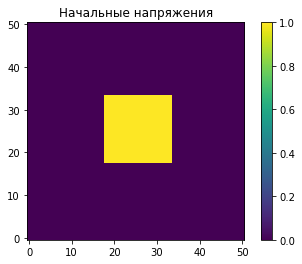

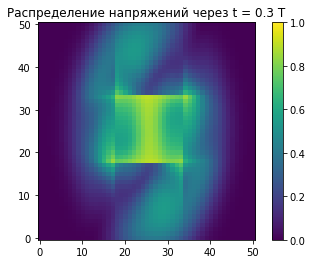

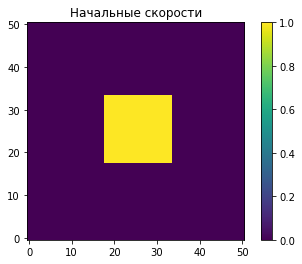

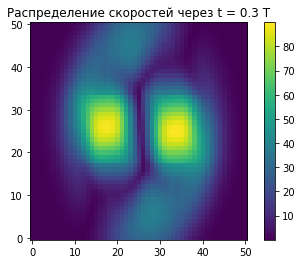

In [126]:
fig1, ax1 = plt.subplots()
ax1.set_title('Начальные напряжения')
img1 = ax1.imshow(np.sqrt(data_start['sxx'] ** 2 + data_start['syy'] ** 2 + 4 * data_start['sxy'] ** 2), vmin = 0, vmax = 1, origin = 'lower')
plt.colorbar(img1)
fig2, ax2 = plt.subplots()
ax2.set_title('Распределение напряжений через t = ' + str(T / (L / max(c1x, c2x, c1y, c2y))) + ' T')
#_ = ax2.set_xlabel('Горизонталь OX, м')
#_ = ax2.set_ylabel('Вертикаль OY, м')
img2 = ax2.imshow(np.sqrt(data_current['sxx'] ** 2 + data_current['syy'] ** 2 + 4 * data_current['sxy'] ** 2), vmin = 0, vmax = 1, origin = 'lower')
plt.colorbar(img2)

fig3, ax3 = plt.subplots()
ax3.set_title('Начальные скорости')
img3 = ax3.imshow(np.sqrt(data_start['vx'] ** 2 + data_start['vy'] ** 2), vmin = 0, vmax = 1, origin = 'lower')
plt.colorbar(img3)
fig4, ax4 = plt.subplots()
ax4.set_title('Распределение скоростей через t = ' + str(T / (L / max(c1x, c2x, c1y, c2y))) + ' T')
#_ = ax2.set_xlabel('Горизонталь OX, м')
#_ = ax2.set_ylabel('Вертикаль OY, м')
img4 = ax4.imshow(np.sqrt(data_current['vx'] ** 2 + data_current['vy'] ** 2), origin = 'lower')
plt.colorbar(img4)
